In [1]:
import numpy as np
from matplotlib import pyplot as plt

# A Simple Bayesian Thermostat

## By André van Schaik

### __[International Centre for Neuromorphic Systems](https://westernsydney.edu.au/icns)__        24/12/2018

I made this notebook based on __[The free energy principle for action and perception : A mathematical review](https://www.sciencedirect.com/science/article/pii/S0022249617300962)__ , Journal of Mathematical Psychology
Christopher L . Buckley , Chang Sub Kim, Simon M. McGregor and Anil K. Seth.

This paper does a good job of going through the mathematics of the Free Energy Principle and Active Inference. 

The example in the paper implements an agent that senses the temperature, and the spatial derivative of the temperature. These vary in the agent's environment with position $\theta$, according to:

\begin{align*}
T(\theta) &= \frac{T_0}{\theta^2 + 1}\\
\frac{dT}{d\theta} &= -T_0\frac{2\theta}{(\theta^2 + 1)^2}.
\end{align*}

The agent senses the temperature and the time derivative of the temperature with noisy sensors:

\begin{align*}
\phi & = T(\theta) + zgp\\
\phi' &= \frac{dT}{d\theta}\theta' + zgp'.
\end{align*}

The agent has a preferred set of target values for these and can take an action $a$ to move to these target values. In this case the action taken simply sets the velocity of the agent:

\begin{align*}
\theta' = a
\end{align*}

The agent  has beliefs about how its sensory data relates to the temperature in its environment. In this case:

\begin{align*}
\phi &= \mu + z\\
\phi' &= \mu' + z'\\
\end{align*}

The agent also has an internal belief state $\mu$ that represents its estimate of the temperature of its environment. The paper above goes on to define a generative model in *general coordinates* up to third order:

\begin{align*}
\mu' &= \mu + w\\
\mu'' &= \mu' + w'\\
\mu''' &= w''.
\end{align*}

It seems to me there is an issue with such a definition. Whatever unit $\mu$ has, $\mu'$ is its time derivative, and has different units. In this case, $\mu$ is a temperature, so its units are $[K]$, so that $\mu'$ has units $[Ks^{-1}]$. The same goes for the other levels. If we are to interpret $w$ as noise in the agent's internal representation of the temperature, then $w$ has the same units at $\mu$. We can correct this by including a time constant, $\tau$, in these equations and rewrite:

\begin{align*}
\tau\mu' &= \mu + w\\
\tau\mu'' &= \mu' + w'\\
\tau\mu''' &= w''.
\end{align*}

I assume that $\tau = 1[s]$. Even with this correction, the second line has units of $[1/s]$, and the third line has units of $[1/s^2]$. The equation for Laplace-encoded Energy (see below), however, has terms that include the log of the variance of the noise components, including of $w'$, $w''$ and $z'$. This means all these need to be dimensionless random variables. To allow this interpretation, we have to make all the terms in the equations above dimensionless as follows:

\begin{align*}
\phi &= \mu + z\\
\tau\phi' &= \tau\mu' + z'\\
\tau\mu' &= \mu + w\\
\tau^2\mu'' &= \tau\mu' + w'\\
\tau^3\mu''' &= w''.
\end{align*}


Using the Laplace-encoded Energy (LEE) as a proxy for the Variational Free Energy (VFE), under the assumption that the recognition density is a sharply peaked Gaussian around its mean value, optimisation proceeds by calculating (dimensionless) error terms between $\phi$ and $\mu$, and between the various orders of $\mu$:

\begin{align*}
\epsilon_{z[0]} &= \phi - \mu \\
\epsilon_{z[1]} &= \tau\phi'- \tau\mu' \\
\epsilon_{w[0]} &= \tau \mu' + \mu - target_{[0]} \\
\epsilon_{w[1]} &= \tau^2 \mu'' + \tau\mu' - \tau target_{[1]}) \\
\end{align*}

In first instance we will use $target_{[0]} = T_{desire}/T_{ref}$ and $target_{[1]} = 0$, where $T_{ref} = 1 \:[^\circ K]$.

The gradient descent method using general coordinates is now given by:

\begin{align*}
\tau^n (\dot\mu_{[n]} - D\mu_{[n]}) = -\kappa \nabla_{\tau^n \tilde\mu} E(\tilde\mu, \tilde\phi) \\
\end{align*}

Here $\kappa$ is a rate, and has units of $[s^{-1}]$. Working through this results in the following update equations:

\begin{align*}
\frac{\Delta \mu}{\Delta t} &= \mu' - \kappa \left[-\frac{\epsilon_{z[0]}}{\sigma_{z[0]}} + \frac{\epsilon_{w[0]}}{\sigma_{w[0]}} \right] \\
\frac{\Delta \mu'}{\Delta t} &= \mu'' - \frac{\kappa}{\tau} \left[-\frac{\epsilon_{z[1]}}{\sigma_{z[1]}} + \frac{\epsilon_{w[1]}}{\sigma_{w[1]}} + \frac{\epsilon_{w[0]}}{\sigma_{w[0]}} \right] \\
\frac{\Delta \mu''}{\Delta t} &= - \frac{\kappa}{\tau^2} \frac{\epsilon_{w[1]}}{\sigma_{w[1]}}
\end{align*}

I've discretised time here on the LHS to indicate the iterative procedure of updating its belief. 

The agent not only updates its beliefs, but also takes action to minimise its Free Energy. To do this, we first need to make the equations that generate sensory output and that define $a$ dimensionless too:

\begin{align*}
\phi & = \frac{T(\theta)}{T_{ref}} + zgp\\
\tau\phi' &= \frac{\tau\theta'}{T_{ref}} \frac{dT}{d\theta} + zgp' \\
a &= \tau\theta'
\end{align*}

we can write:

\begin{align*}
\frac{\Delta a}{\Delta t} &= -\kappa_a \left[ \frac{dE(\tilde\mu, \tilde\phi)}{da} \right] \\
&= -\kappa_a \left[ \frac{dE(\tilde\mu, \tilde\phi)}{d\tau\phi'}\frac{d\tau\phi'}{da} \right] \\
&= -\kappa_a \left[ \frac{\epsilon_{z[1]}}{\sigma_{z[1]}}\frac{dT}{d\theta} \right] \\
\end{align*}



First, we reproduce the results from Figure 4 in the paper.

In [2]:
def temperature(theta):
    ''' Generative process '''    
    T = T0 / ( theta[0]**2 + 1)
    Ttheta = -2 * T0 * theta[0] * (theta[0]**2 + 1)**-2
    T_dot = Ttheta * theta[1]
    return [T, T_dot, Ttheta]


def LEEnergy(phi, mu, target):
    ''' Laplace-Encoded Energy = Variational Free Energy + Entropy
    This assumes the R-density is Gaussian, and sharply peaked around mu '''
    epsilon_z[0] = phi[0] - mu[0]
    epsilon_z[1] = tau * phi[1] - tau * mu[1]
    epsilon_w[0] = tau * mu[1] + mu[0] - target[0]
    epsilon_w[1] = tau**2 * mu[2] + tau * mu[1] - tau * target[1]
    LEE = (  np.dot(1/var_z, epsilon_z**2)
           + np.dot(1/var_w, epsilon_w**2)
           + np.log(var_w[0] * var_w[1] * var_z[0] * var_z[1])) / 2.0
    return (LEE, epsilon_z, epsilon_w)


def update_belief(mu, epsilon_z, epsilon_w):
    ''' Update agent's belief state
    Note: this doesn't use VFE or LEE at all, just the variance weighted error terms! '''
    mu[0] += dt * (mu[1] - k * (-epsilon_z[0] / var_z[0] + epsilon_w[0] / var_w[0])) 
    mu[1] += dt * (mu[2] - k / tau * (-epsilon_z[1] / var_z[1] + epsilon_w[1] / var_w[1] + epsilon_w[0] / var_w[0])) 
    mu[2] += dt * -k /tau**2 * (epsilon_w[1] / var_w[1])
    return mu


def update_action(a, T, epsilon_z):
    a += dt * -ka * T[2] * epsilon_z[1] / var_z[1]
    return a


def update_position(theta, a):
    theta[1] = a / tau
    theta[0] += dt * theta[1]
    T = temperature(theta)
    return (theta, T)


def update_sensors(T):
    phi = T[0:2] + var_zgp**0.5 * np.random.randn(1,2)
    return phi

    
def sim_agent():
    ''' Simulate agent '''
    
    for i in range(N):
        
        # Calculate prediction errors using the generative model and received sensory input
        (LEE[i], epsilon_z, epsilon_w) =  LEEnergy(phi[:, i-1], mu[:, i-1], target[:, i-1])

        # Update beliefs using gradient descent for one step
        mu[:, i] = update_belief(mu[:, i-1], epsilon_z, epsilon_w)  

        if (t[i] > actionTime):
            # allow movement, i.e., active inference
            a[i] = update_action (a[i-1], T[:, i-1], epsilon_z) 
        else:
            # passive inference
            a[i] = 0

        # Move in the real world using action a
        (theta[:, i], T[:, i]) = update_position(theta[:, i-1], a[i])

        # Calculate new sensory input
        phi[:, i] = update_sensors(T[:, i])

In [3]:
def default_params():
    ''' Set global constants for simulation'''

    # These are declared globals so the can be used in all functions above
    global simTime, dt, actionTime, tau, t, N, T_desire, T0, IP, var_z, var_zgp, var_w, k, ka
    
    # Simulation parameters
    simTime = 100                       # Simulation duration
    dt = 0.001                          # Simulation time step
    actionTime = simTime/4              # The time that action onsets
    tau = 1.0                           # Time constant for generalised motion
    t = np.arange(0, simTime, dt)       # Time
    N = t.size                          # Number of simulation steps

    # Generative Model Parameters
    T_desire = 4                        # Desired temperature
    T0 = 100                            # Temperature at theta = 0
    IP = 2                              # Inital position

    # Variances
    var_z = 0.1 * np.ones(2)            # Sensory variances
    var_zgp = 0.1 * np.ones(2)          # Sensory noise in the generative process
    var_w = 0.1 * np.ones(2)            # Hidden state variances

    # Gradient descent learning parameters
    k = 0.1                             # For inference
    ka = 0.01                           # For action selection

    
def reset_vars():
    ''' lazy programming to reset variables'''
    
    # These are variables and passed into function calls where needed
    # The only reason to make them globals here is to enable simple calling of a reset function to (re)initialise them
    global phi, mu, a, theta, T, LEE, epsilon_z, epsilon_w, target

    # Initialise variable arrays
    phi = np.zeros((2, N))              # Temperature sensor output
    mu = np.zeros((3, N))               # Agent belief for temperature
    a = np.zeros(N)                     # Action (= velocity)
    theta = np.zeros((2, N))            # Position
    theta[0, -1] = IP                   # Initial position
    T = np.zeros((3,N))                 # Temperature
    LEE = np.zeros(N)                   # Laplace-Encoded Energy
    epsilon_z = np.zeros(2)             # Error terms between phi and mu
    epsilon_w = np.zeros(2)             # Error terms between mu and target
    target = np.zeros((2, N))           # Target temperature and derivative
    target[0] += T_desire

    
def plot_fig1():
    f, axarr = plt.subplots(5, sharex=True, figsize=(8, 8)) 
    f.subplots_adjust(hspace=0)
    axarr[0].plot(t, T[0])
    axarr[0].plot(t, theta[0])
    axarr[0].plot(t, target[0])
    axarr[0].legend(('T', r'$\vartheta$', 'Target'), loc = 'upper right')

    axarr[1].plot(t, mu[0], 'k')
    axarr[1].plot(t, tau*mu[1], 'm')
    axarr[1].plot(t, tau**2*mu[2], 'b')
    axarr[1].legend((r'$\mu$', r'$\tau\mu^{\prime}$', r'$\tau^2\mu^{\prime\prime}$'), loc = 'upper right') 
    axarr[1].xaxis.set_tick_params(tick2On = True)

    axarr[2].plot(t, phi[0], 'k')
    axarr[2].plot(t, tau*phi[1], 'm')
    axarr[2].legend((r'$\varphi$', r'$\tau\varphi^{\prime}$'), loc = 'upper right')
    axarr[2].xaxis.set_tick_params(tick2On = True)

    axarr[3].plot(t, a, 'k') 
    axarr[3].legend('a', loc = 'upper right')
    axarr[3].xaxis.set_tick_params(tick2On = True)

    axarr[4].plot(t, LEE, 'k')
    axarr[4].legend(("LEE",), loc = 'upper right')
    axarr[4].xaxis.set_tick_params(tick2On = True)
    axarr[4].set(xlabel = 'time')
    

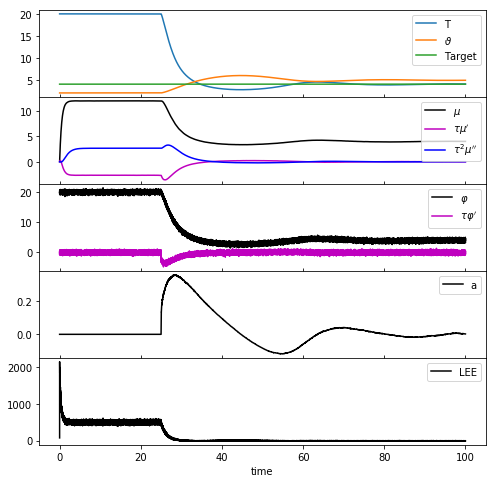

In [4]:
# Simulate agent
default_params()
reset_vars()
sim_agent()
plot_fig1()

Next, we up the learning rate:

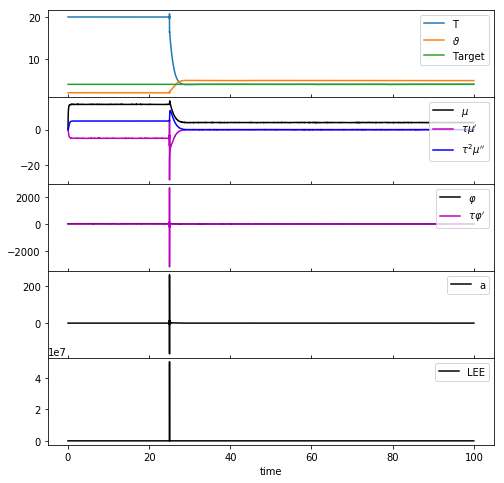

In [5]:
default_params()
k = 1
ka = 1

reset_vars()
sim_agent()
plot_fig1()

Another way to speed up moving to the target is by reducing the variances.

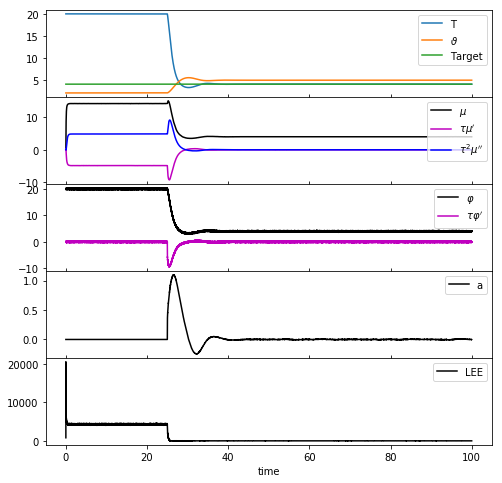

In [6]:
default_params()

# Variances
var_z = 0.01 * np.ones(2)            # Sensory variances
var_zgp = 0.01 * np.ones(2)          # Sensory noise in the generative process
var_w = 0.01 * np.ones(2)            # Hidden state variances

reset_vars()
sim_agent()
plot_fig1()

However, combining the two leads to an instability as the rate of adaptation is now too large:

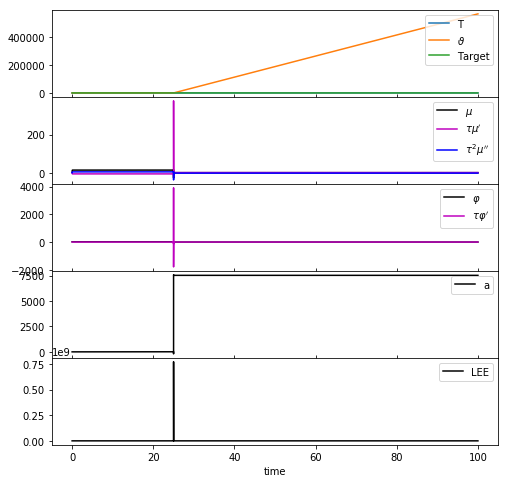

In [7]:
default_params()

k = 1.0
ka = 1.0
var_z = 0.01 * np.ones(2)
var_zgp = 0.01 * np.ones(2)
var_w = 0.01 * np.ones(2)

reset_vars()
sim_agent()
plot_fig1()

If we re-run the original simulation ...

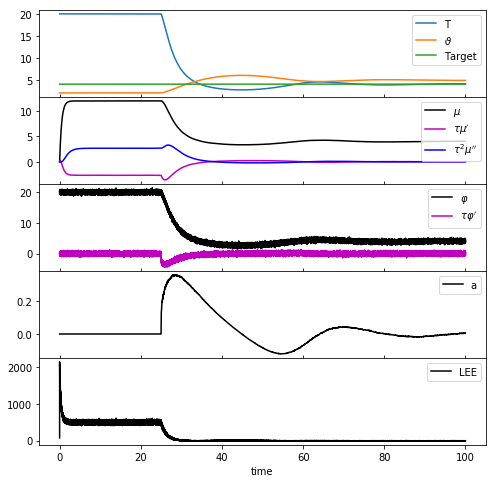

In [8]:
default_params()
reset_vars()

sim_agent()
plot_fig1()

.. and continue the simulation without resetting any variables, we get a zoomed in figure around the final values.

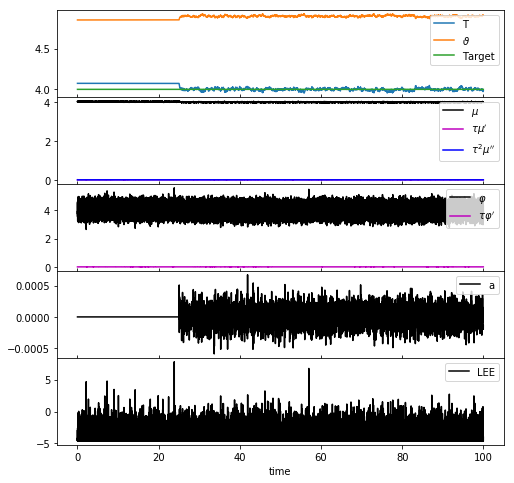

In [9]:
default_params()

k = 1
ka = 1
tau = dt

# reset_vars()
sim_agent()
plot_fig1()

**However, I think $\tau$ should be equal to $dt$, as this is our one unit of time for simulation.** Once we do this, we get results that are quite different from the paper.

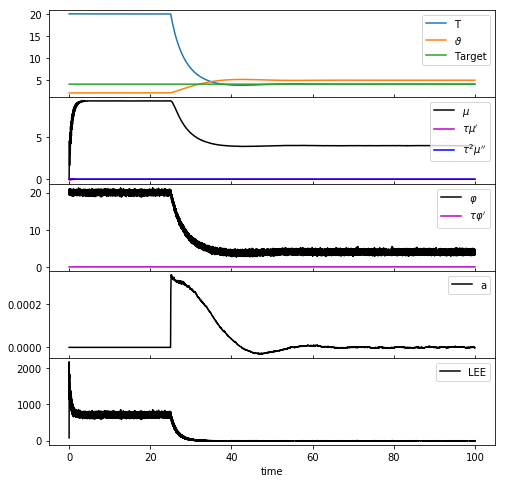

In [10]:
default_params()

tau = dt

reset_vars()
sim_agent()
plot_fig1()

With a high learning rate, this gives very fast convergence.

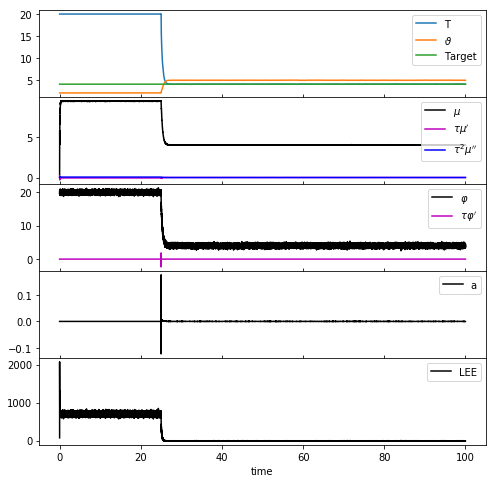

In [11]:
default_params()

tau = dt
k = 1.0
ka = 1.0

reset_vars()
sim_agent()
plot_fig1()

And zooming in:

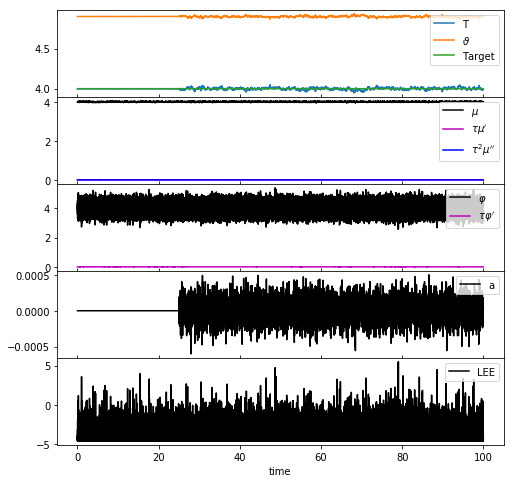

In [12]:
default_params()

tau = dt
k = 1.0
ka = 1.0

# reset_vars()
sim_agent()
plot_fig1()

If all is well, the agent's behaviour should be independent of the timestep used in the simulation (as long as `dt` is small enough).

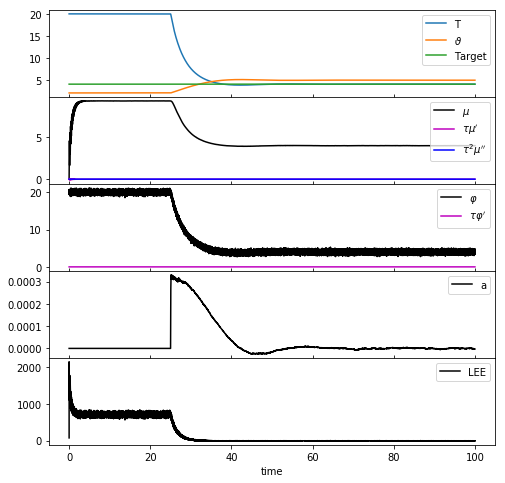

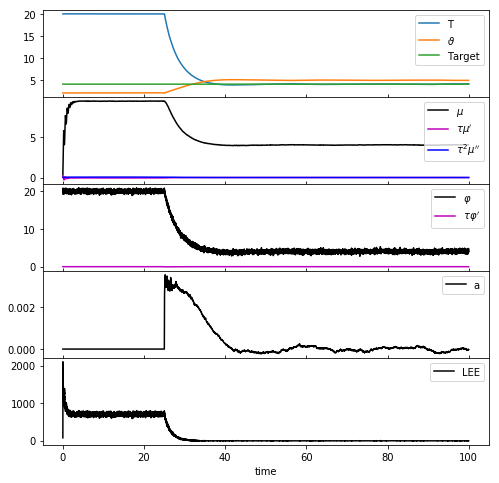

In [13]:
default_params()

tau = dt

reset_vars()
sim_agent()
plot_fig1()

default_params()
dt = 0.01
t = np.arange(0, simTime, dt)
N = t.size
tau = dt

reset_vars()
sim_agent()
plot_fig1()

Next, let's define a dynamic target instead of a single fixed temperature.

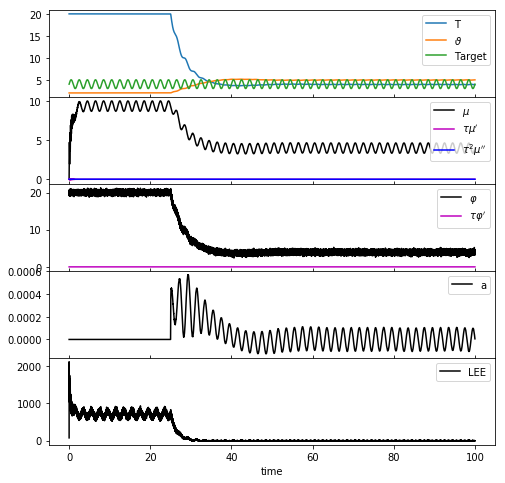

In [14]:
default_params()

tau = dt

reset_vars()

# Create dynamic target
f = 0.5
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

Clearly, with the default learning rates, the agent is unable to follow the high frequency of the target and settles on the mean value instead. However, if we increase the learning rate, the agent follows the target very well.

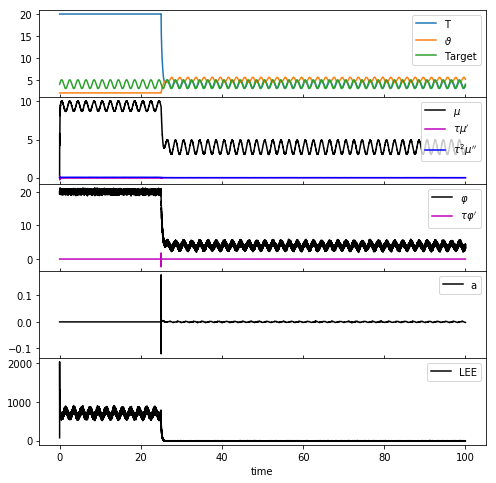

In [15]:
default_params()

tau = dt
k = 1.0
ka = 1.0

reset_vars()

# Create dynamic target
f = 0.5
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

And zooming in:

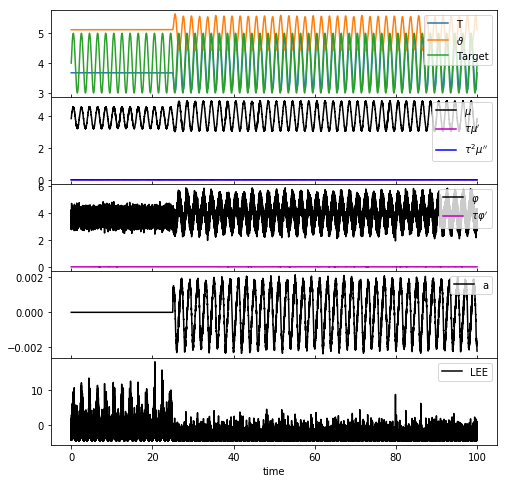

In [16]:
default_params()

tau = dt
k = 1.0
ka = 1.0

# reset_vars()

# Create dynamic target
f = 0.5
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

However, with our initial $\tau = 1$, the agent is unable to follow the dynamic target at this speed, even with the high learning rates.

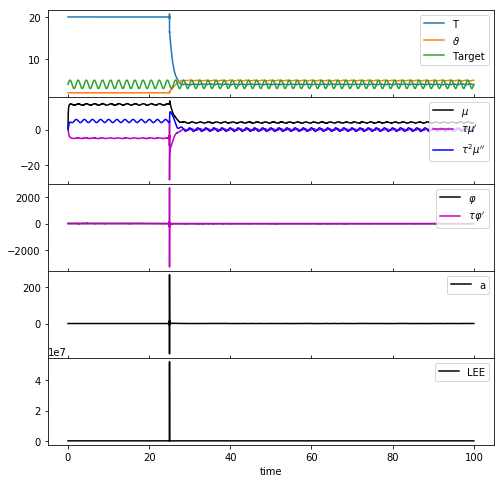

In [17]:
default_params()

tau = 1
k = 1.0
ka = 1.0

reset_vars()

# Create dynamic target
f = 0.5
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

Returning to $\tau = dt$, and reducing the frequency of the target, allows the agent to do very well indeed.

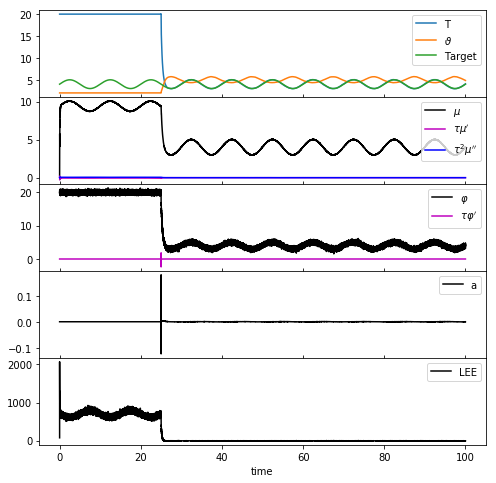

In [18]:
default_params()

tau = dt
k = 1.0
ka = 1.0

reset_vars()

# Create dynamic target
f = 0.1
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

Next, lets look at increasing the variances by a factor 10 in turn, without resetting the variables, so we get a nice zoom in the graphs below, close to the final solution.

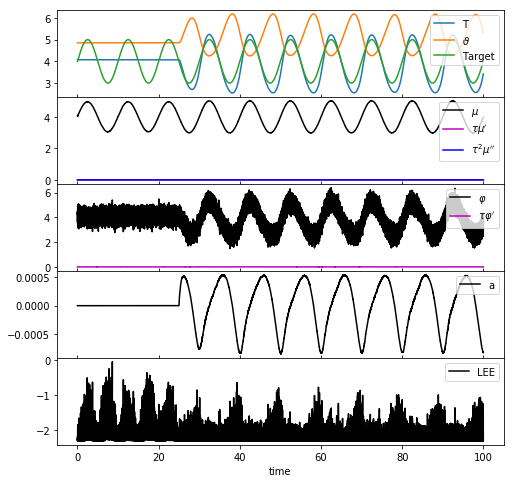

In [19]:
default_params()

tau = dt
k = 1.0
ka = 1.0
var_z = 1.0 * np.ones(2)
var_zgp = 0.1 * np.ones(2)
var_w = 0.1 * np.ones(2)

# reset_vars()

# Create dynamic target
f = 0.1
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

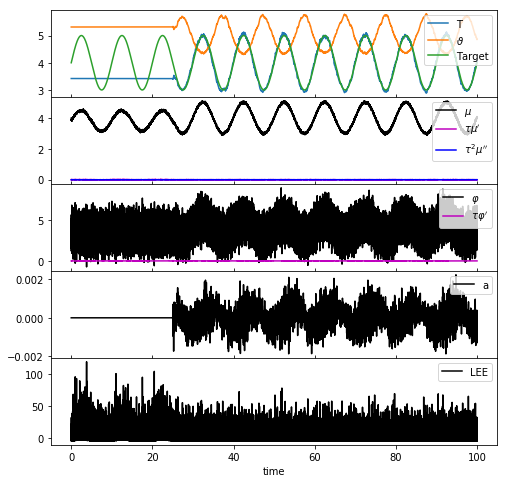

In [20]:
default_params()

tau = dt
k = 1.0
ka = 1.0
var_z = 0.1 * np.ones(2)
var_zgp = 1.0 * np.ones(2)
var_w = 0.1 * np.ones(2)

# reset_vars()

# Create dynamic target
f = 0.1
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

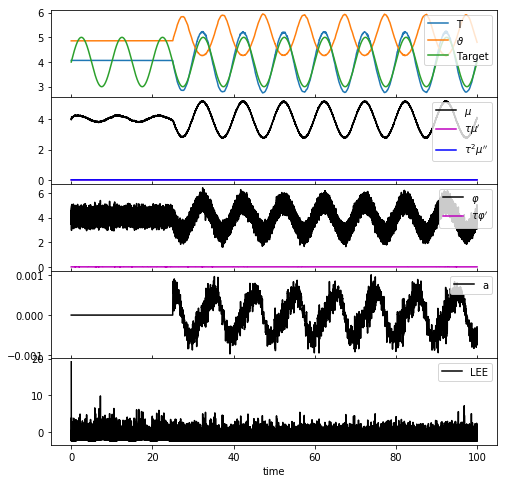

In [21]:
default_params()

tau = dt
k = 1.0
ka = 1.0
var_z = 0.1 * np.ones(2)
var_zgp = 0.1 * np.ones(2)
var_w = 1.0 * np.ones(2)

# reset_vars()

# Create dynamic target
f = 0.1
target = np.asarray([T_desire + np.sin(2*np.pi*f*t), np.cos(2*np.pi*f*t)])

# Simulate agent
sim_agent()
plot_fig1()

Clearly, not trusting your sensors leads to a big deterioration in performance, whereas actual sensory noise is not that important and just makes actions more noisy. Not trusting your internal state leads to overshoot, but still very good performance. 